In [ ]:
############# AT THE START, WE INSTALL PACKAGES WE NEED ###################################

# We use a package that might be new to some of you, called "INLA" 
# This package helps implement Bayesian methods and helps make some of our steps fast/easy to implement
# We will explain it as we go through this code 

############# OPEN R, THEN RUN THE FOLLOWING COMMAND ###################

# install.packages("INLA",repos=c(getOption("repos"),INLA="https://inla.r-inla-download.org/R/stable"), dep=TRUE)
# install.packages("fmesher", dependencies = TRUE)
# install.packages("MatrixModels", type = "source")
# install.packages("exactextractr")
install.packages("sn" ,dependencies = TRUE)
packages <- c("terra","dplyr","spdep", "exactextractr", "sf","ggplot2","viridis","sn","fmesher","exactextractr","fields")
package.check <- lapply(packages, FUN = function(x) {
    if (!require(x, character.only = TRUE)) {
        install.packages(x, dependencies = TRUE)
        library(x, character.only = TRUE, quietly=TRUE)
    }
})
Sys.setenv("AWS_DEFAULT_REGION" = 'us-west-2')

# ##### THE FOLLOWING COMMANDS ARE FOR THE INSTALLATION OF PACKAGES ON NASA MAAP #####
# ##### CONDA-FORGE YOUR WAY THROUGH PACKAGES THAT DID NOT INSTALL ##########

# conda install conda-forge::r-fmesher
# conda install conda-forge::r-exactextractr
# conda install conda-forge::r-sn
# conda install conda-forge::r-inlabru
# conda install conda-forge::r-fields

In [1]:
############## LOAD PACKAGES ###########

# library("fmesher")
# library(MatrixModels)
# library(Matrix)
# library(INLA)
# library(inlabru)
# library("jpeg")

library(sf)
library(terra)
library(dplyr)
library(spdep)
library(raster)
library(exactextractr)
library(stringr)

library(ggplot2)
library(viridis)
# library(sn)

Linking to GEOS 3.11.2, GDAL 3.7.0, PROJ 9.2.0; sf_use_s2() is TRUE

terra 1.7.29


Attaching package: ‘dplyr’


The following objects are masked from ‘package:terra’:

    intersect, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: spData

To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`

Loading required package: sp


Attaching package: ‘raster’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: viridisLite



In [ ]:
Mongolia <- st_read('/projects/my-private-bucket/Data/NFI_data/Mongolia/240924_NFI_6933.gpkg') %>% filter( is.na(st_dimension(.)) == FALSE )#%>% st_transform(crs=6933)
plot(Mongolia)
colnames(Mongolia)
Mongolia['AGB'] = Mongolia$coverted.to.GS.ha
Mongolia_PSU <- aggregate(x= Mongolia, list(Mongolia$Unit_ID), FUN = mean)
# st_write(Mongolia_PSU,'/projects/my-private-bucket/Data/NFI_data/Mongolia/240924_NFI_PSU_6933.gpkg')

In [102]:
# cci.rast <- rast("/projects/my-public-bucket/Data/NASA_CMS_2023/MONGOLIA/MNG/MNG_Product_AOI/CCI_AOImasked.tif") %>% project("epsg:6933")
# gedi.rast <- rast("/projects/my-public-bucket/Data/Biomass_maps/GEDI_L4B_v21/GEDI04_B_MW019MW223_02_002_02_R01000M_MU.tif")
# GEDI.plot <- GEDI %>% st_as_sf(crs = 4326, coords = c("x" = "lon_lowestmode", "y" = "lat_lowestmode"), remove = F) %>% st_transform(crs = 6933)
# cci.plot = exactextractr::exact_extract(cci.rast, st_buffer(Mongolia_PSU,100), 'mean')
# gedi.plot = exactextractr::exact_extract(gedi.rast, st_buffer(Mongolia_PSU,100), 'mean')

# DATA = as.data.frame(cbind(GEDI.plot$AGBD,cci.plot,nceo.plot,st_coordinates(GEDI.plot)[,1],st_coordinates(GEDI.plot)[,2]))
# colnames(DATA) = c("gedi.agbd","cci.agbd","nceo.agbd","X","Y")
# write.csv(DATA,"/projects/my-public-bucket/Data/NASA_CMS_2023/Mongolia/CCI_GEDIL4A.csv",row.names=FALSE) #Save the data

# rm(cci.rast,nceo.rast,GEDI,GEDI.plot,cci.plot,nceo.plot)
# plot(Mongolia_PSU$AGB,gedi.plot)
# plot(Mongolia_PSU$AGB,cci.plot)

In [13]:
### READ BOREAL TILES AND EXTRACT AGB VALUES

FOLDER <- "/projects/my-public-bucket/Data/NASA_CMS_2023/MONGOLIA/MNG/BOREAL_files/"
BOREAL_FILES <- list.files(path = FOLDER, pattern = ("*.tif"), full.names = TRUE)
BOREAL_FILES_DF <- as.data.frame(str_c(Mongolia$Unit_ID,'_',Mongolia$Plot_ID))
for (each_boreal in BOREAL_FILES){
    file.rast <- rast(each_boreal) %>% project("epsg:6933")
    file.plot = exactextractr::exact_extract(file.rast, st_buffer(Mongolia,20), 'mean')
    BOREAL_FILES_DF <- cbind(BOREAL_FILES_DF,file.plot)
}
BOREAL_FILES_DF <- BOREAL_FILES_DF[,!grepl("standard_deviation", colnames(BOREAL_FILES_DF))]
BOREAL_AGBD_SSU <- cbind(as.data.frame(str_c(Mongolia$Unit_ID,'_',Mongolia$Plot_ID)),as.data.frame(rowMeans(BOREAL_FILES_DF[,2:ncol(BOREAL_FILES_DF)],na.rm=TRUE)))
colnames(BOREAL_AGBD_SSU) = c("SSU_ID","Boreal_AGB")
write.csv(BOREAL_AGBD_SSU,"/projects/my-public-bucket/Data/NASA_CMS_2023/MONGOLIA/MNG/BOREAL_files/Boreal_AGB_SSU.csv")

FOLDER <- "/projects/my-public-bucket/Data/NASA_CMS_2023/MONGOLIA/MNG/BOREAL_files/"
BOREAL_FILES <- list.files(path = FOLDER, pattern = ("*.tif"), full.names = TRUE)
BOREAL_FILES_DF <- as.data.frame(Mongolia_PSU$Unit_ID)
for (each_boreal in BOREAL_FILES){
    file.rast <- rast(each_boreal) %>% project("epsg:6933")
    file.plot = exactextractr::exact_extract(file.rast, st_buffer(Mongolia_PSU,100), 'mean')
    BOREAL_FILES_DF <- cbind(BOREAL_FILES_DF,file.plot)
}
BOREAL_FILES_DF <- BOREAL_FILES_DF[,!grepl("standard_deviation", colnames(BOREAL_FILES_DF))]
BOREAL_AGBD_PSU <- cbind(as.data.frame(Mongolia_PSU$Unit_ID),as.data.frame(rowMeans(BOREAL_FILES_DF[,2:ncol(BOREAL_FILES_DF)],na.rm=TRUE)))
colnames(BOREAL_AGBD_PSU) = c("PSU_ID","Boreal_AGB")
write.csv(BOREAL_AGBD_PSU,"/projects/my-public-bucket/Data/NASA_CMS_2023/MONGOLIA/MNG/BOREAL_files/Boreal_AGB_PSU.csv")

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

In [9]:
### READ BOREAL TILES AND EXTRACT HEIGHT VALUES

FOLDER <- "/projects/my-public-bucket/Data/NASA_CMS_2023/MONGOLIA/MNG/BOREAL_heights/"
BOREAL_FILES <- list.files(path = FOLDER, pattern = ("*.tif"), full.names = TRUE)
BOREAL_FILES_DF <- as.data.frame(str_c(Mongolia$Unit_ID,'_',Mongolia$Plot_ID))
for (each_boreal in BOREAL_FILES){
    file.rast <- rast(each_boreal) %>% project("epsg:6933")
    file.plot = exactextractr::exact_extract(file.rast, st_buffer(Mongolia,20), 'mean')
    BOREAL_FILES_DF <- cbind(BOREAL_FILES_DF,file.plot)
}
BOREAL_FILES_DF <- BOREAL_FILES_DF[,!grepl("sd", colnames(BOREAL_FILES_DF))]
BOREAL_HEIGHTS_SSU <- cbind(as.data.frame(str_c(Mongolia$Unit_ID,'_',Mongolia$Plot_ID)),as.data.frame(rowMeans(BOREAL_FILES_DF[,2:ncol(BOREAL_FILES_DF)],na.rm=TRUE)))
colnames(BOREAL_HEIGHTS_SSU) = c("SSU_ID","Boreal_Height")
write.csv(BOREAL_HEIGHTS_SSU,"/projects/my-public-bucket/Data/NASA_CMS_2023/MONGOLIA/MNG/BOREAL_heights/Boreal_Height_SSU.csv")

FOLDER <- "/projects/my-public-bucket/Data/NASA_CMS_2023/MONGOLIA/MNG/BOREAL_heights/"
BOREAL_FILES <- list.files(path = FOLDER, pattern = ("*.tif"), full.names = TRUE)
BOREAL_FILES_DF <- as.data.frame(Mongolia_PSU$Unit_ID)
for (each_boreal in BOREAL_FILES){
    file.rast <- rast(each_boreal) %>% project("epsg:6933")
    file.plot = exactextractr::exact_extract(file.rast, st_buffer(Mongolia_PSU,100), 'mean')
    BOREAL_FILES_DF <- cbind(BOREAL_FILES_DF,file.plot)
}
BOREAL_FILES_DF <- BOREAL_FILES_DF[,!grepl("mean.sd", colnames(BOREAL_FILES_DF))]
BOREAL_HEIGHTS_PSU <- cbind(as.data.frame(Mongolia_PSU$Unit_ID),as.data.frame(rowMeans(BOREAL_FILES_DF[,2:ncol(BOREAL_FILES_DF)],na.rm=TRUE)))
colnames(BOREAL_HEIGHTS_PSU) = c("PSU_ID","Boreal_Height")
write.csv(BOREAL_HEIGHTS_PSU,"/projects/my-public-bucket/Data/NASA_CMS_2023/MONGOLIA/MNG/BOREAL_heights/Boreal_Height_PSU.csv")

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

In [24]:
### READ GEDI TILES AND EXTRACT HEIGHT VALUES

FOLDER <- "/projects/my-public-bucket/Data/NASA_CMS_2023/MONGOLIA/GRID/"
GEDI_FILES <- list.files(path = FOLDER, pattern = ("*.tif"), full.names = TRUE)
GEDI_FILES_DF <- as.data.frame(str_c(Mongolia$Unit_ID,'_',Mongolia$Plot_ID))
for (each_GEDI in GEDI_FILES){
    file.rast <- rast(each_GEDI) %>% project("epsg:6933")
    file.plot = exactextractr::exact_extract(file.rast, st_buffer(Mongolia,20), 'mean')
    GEDI_FILES_DF <- cbind(GEDI_FILES_DF,file.plot)
}
GEDI_FILES_DF <- GEDI_FILES_DF[,!grepl("sd", colnames(GEDI_FILES_DF))]
GEDI_HEIGHTS_SSU <- cbind(as.data.frame(str_c(Mongolia$Unit_ID,'_',Mongolia$Plot_ID)),as.data.frame(rowMeans(GEDI_FILES_DF[,2:ncol(GEDI_FILES_DF)],na.rm=TRUE)))
colnames(GEDI_HEIGHTS_SSU) = c("SSU_ID","GEDI_Height")
write.csv(GEDI_HEIGHTS_SSU,"/projects/my-public-bucket/Data/NASA_CMS_2023/MONGOLIA/GRID/GEDI_Height_SSU.csv")

FOLDER <- "/projects/my-public-bucket/Data/NASA_CMS_2023/MONGOLIA/GRID/"
GEDI_FILES <- list.files(path = FOLDER, pattern = ("*.tif"), full.names = TRUE)
GEDI_FILES_DF <- as.data.frame(Mongolia_PSU$Unit_ID)
for (each_GEDI in GEDI_FILES){
    file.rast <- rast(each_GEDI) %>% project("epsg:6933")
    file.plot = exactextractr::exact_extract(file.rast, st_buffer(Mongolia_PSU,100), 'mean')
    GEDI_FILES_DF <- cbind(GEDI_FILES_DF,file.plot)
}
GEDI_FILES_DF <- GEDI_FILES_DF[,!grepl("mean.sd", colnames(GEDI_FILES_DF))]
GEDI_HEIGHTS_PSU <- cbind(as.data.frame(Mongolia_PSU$Unit_ID),as.data.frame(rowMeans(GEDI_FILES_DF[,2:ncol(GEDI_FILES_DF)],na.rm=TRUE)))
colnames(GEDI_HEIGHTS_PSU) = c("PSU_ID","GEDI_Height")
write.csv(GEDI_HEIGHTS_PSU,"/projects/my-public-bucket/Data/NASA_CMS_2023/MONGOLIA/GRID/GEDI_Height_PSU.csv")

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

Warning message:
“Removed 8 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 8 rows containing missing values or values outside the scale range
(`geom_point()`).”


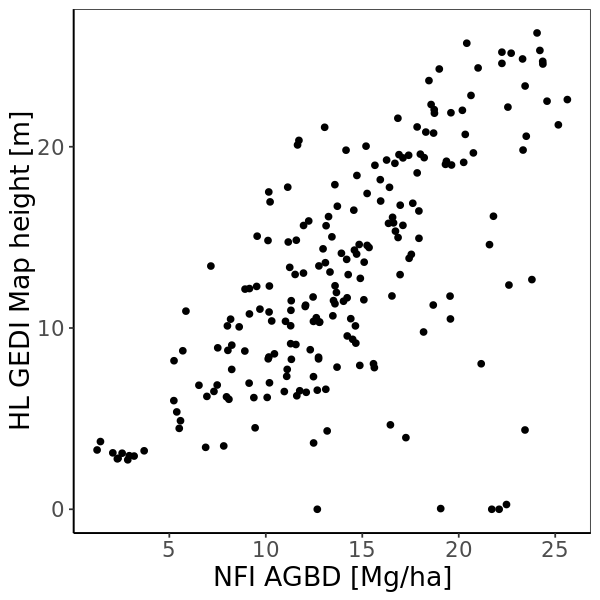

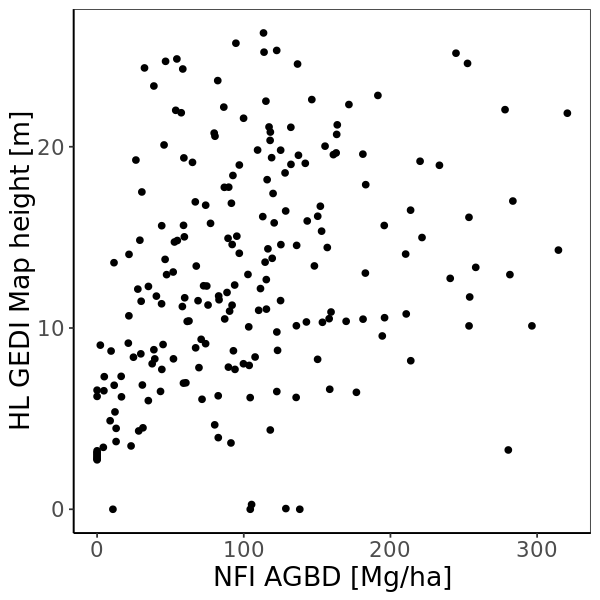

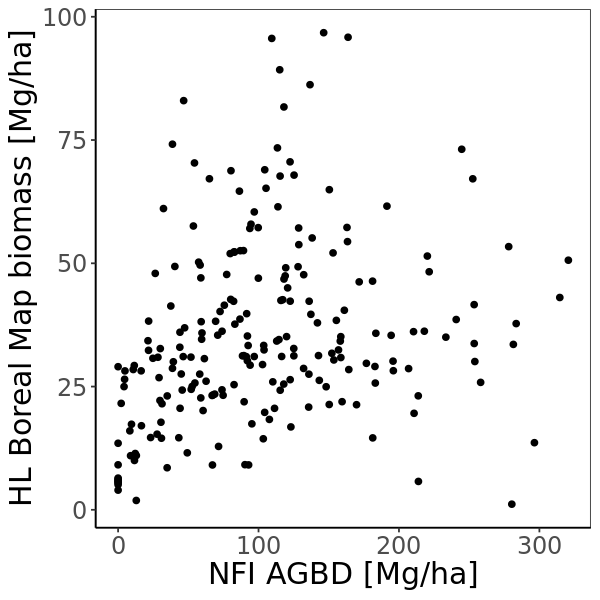

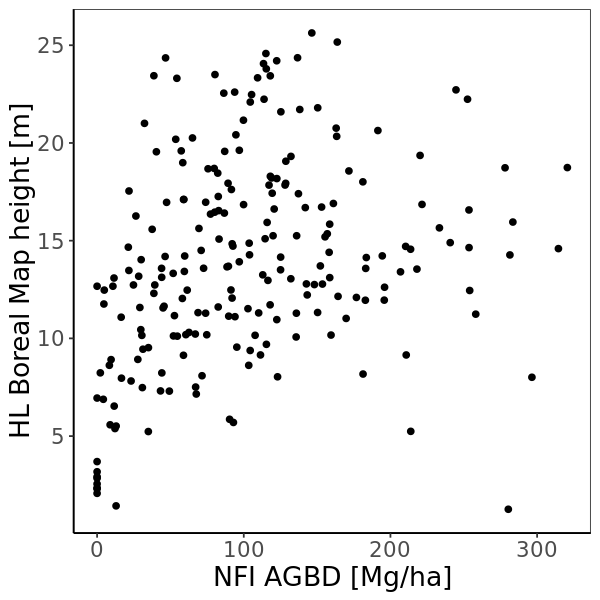

In [36]:
options(repr.plot.width=5, repr.plot.height=5)

BOREAL_HEIGHTS_SSU = read.csv("/projects/my-public-bucket/Data/NASA_CMS_2023/MONGOLIA/MNG/BOREAL_heights/Boreal_Height_SSU.csv")
BOREAL_HEIGHTS_PSU = read.csv("/projects/my-public-bucket/Data/NASA_CMS_2023/MONGOLIA/MNG/BOREAL_heights/Boreal_Height_PSU.csv")
BOREAL_AGBD_PSU = read.csv("/projects/my-public-bucket/Data/NASA_CMS_2023/MONGOLIA/MNG/BOREAL_files/Boreal_AGB_PSU.csv")
BOREAL_AGBD_SSU = read.csv("/projects/my-public-bucket/Data/NASA_CMS_2023/MONGOLIA/MNG/BOREAL_files/Boreal_AGB_PSU.csv")

GGPLOT_DATA <- as.data.frame(cbind(BOREAL_HEIGHTS_PSU$Boreal_Height,GEDI_HEIGHTS_PSU$GEDI_Height)) 
colnames(GGPLOT_DATA) = c("AGB","GEDI_Height")
ggplot(data=GGPLOT_DATA,aes(x=AGB, y=GEDI_Height)) +  geom_point() + 
  xlab("NFI AGBD [Mg/ha]") + ylab("HL GEDI Map height [m]") +
  theme_bw() + theme(text = element_text(size = 16),plot.title = element_text(color="red", size=12, face="bold.italic"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(), axis.line = element_line(colour = "black"))

GGPLOT_DATA <- as.data.frame(cbind(Mongolia_PSU$AGB,GEDI_HEIGHTS_PSU$GEDI_Height)) 
colnames(GGPLOT_DATA) = c("AGB","GEDI_Height")
ggplot(data=GGPLOT_DATA,aes(x=AGB, y=GEDI_Height)) +  geom_point() + 
  xlab("NFI AGBD [Mg/ha]") + ylab("HL GEDI Map height [m]") +
  theme_bw() + theme(text = element_text(size = 16),plot.title = element_text(color="red", size=12, face="bold.italic"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(), axis.line = element_line(colour = "black"))

# GGPLOT_DATA <- as.data.frame(cbind(Mongolia$AGB,GEDI_HEIGHTS_SSU$GEDI_Height)) 
# colnames(GGPLOT_DATA) = c("AGB","GEDI_Height")
# ggplot(data=GGPLOT_DATA,aes(x=AGB, y=GEDI_Height)) +  geom_point() + 
#   xlab("NFI AGBD [Mg/ha]") + ylab("HL GEDI Map height [m]") +
#   theme_bw() + theme(text = element_text(size = 16),plot.title = element_text(color="red", size=12, face="bold.italic"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(), axis.line = element_line(colour = "black"))

GGPLOT_DATA <- as.data.frame(cbind(Mongolia_PSU$AGB,BOREAL_AGBD_PSU$Boreal_AGB)) 
colnames(GGPLOT_DATA) = c("AGB","Boreal_Height")
ggplot(data=GGPLOT_DATA,aes(x=AGB, y=Boreal_Height)) +  geom_point() + 
  xlab("NFI AGBD [Mg/ha]") + ylab("HL Boreal Map biomass [Mg/ha]") +
  theme_bw() + theme(text = element_text(size = 18),plot.title = element_text(color="red", size=12, face="bold.italic"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(), axis.line = element_line(colour = "black"))

GGPLOT_DATA <- as.data.frame(cbind(Mongolia_PSU$AGB,BOREAL_HEIGHTS_PSU$Boreal_Height)) 
colnames(GGPLOT_DATA) = c("AGB","Boreal_Height")
ggplot(data=GGPLOT_DATA,aes(x=AGB, y=Boreal_Height)) +  geom_point() + 
  xlab("NFI AGBD [Mg/ha]") + ylab("HL Boreal Map height [m]") +
  theme_bw() + theme(text = element_text(size = 16),plot.title = element_text(color="red", size=12, face="bold.italic"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(), axis.line = element_line(colour = "black"))

# GGPLOT_DATA <- as.data.frame(cbind(Mongolia$AGB,BOREAL_AGBD_SSU$Boreal_AGB)) 
# colnames(GGPLOT_DATA) = c("AGB","Boreal_Height")
# ggplot(data=GGPLOT_DATA,aes(x=AGB, y=Boreal_Height)) +  geom_point() + 
#   xlab("NFI AGBD [Mg/ha]") + ylab("HL Boreal Map biomass [Mg/ha]") +
#   theme_bw() + theme(text = element_text(size = 18),plot.title = element_text(color="red", size=12, face="bold.italic"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(), axis.line = element_line(colour = "black"))

# GGPLOT_DATA <- as.data.frame(cbind(Mongolia$AGB,BOREAL_HEIGHTS_SSU$Boreal_Height)) 
# colnames(GGPLOT_DATA) = c("AGB","Boreal_Height")
# ggplot(data=GGPLOT_DATA,aes(x=AGB, y=Boreal_Height)) +  geom_point() + 
#   xlab("NFI AGBD [Mg/ha]") + ylab("HL Boreal Map height [m]") +
#   theme_bw() + theme(text = element_text(size = 16),plot.title = element_text(color="red", size=12, face="bold.italic"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(), axis.line = element_line(colour = "black"))


In [41]:
summary(lm(Mongolia_PSU$AGB ~ BOREAL_HEIGHTS_PSU$Boreal_Height * GEDI_HEIGHTS_PSU$GEDI_Height))


Call:
lm(formula = Mongolia_PSU$AGB ~ BOREAL_HEIGHTS_PSU$Boreal_Height * 
    GEDI_HEIGHTS_PSU$GEDI_Height)

Residuals:
    Min      1Q  Median      3Q     Max 
-104.46  -41.93  -13.09   30.46  263.69 

Coefficients:
                                                              Estimate
(Intercept)                                                   -18.3474
BOREAL_HEIGHTS_PSU$Boreal_Height                                5.6030
GEDI_HEIGHTS_PSU$GEDI_Height                                    9.0170
BOREAL_HEIGHTS_PSU$Boreal_Height:GEDI_HEIGHTS_PSU$GEDI_Height  -0.3689
                                                              Std. Error
(Intercept)                                                      23.1123
BOREAL_HEIGHTS_PSU$Boreal_Height                                  1.6300
GEDI_HEIGHTS_PSU$GEDI_Height                                      2.3019
BOREAL_HEIGHTS_PSU$Boreal_Height:GEDI_HEIGHTS_PSU$GEDI_Height     0.1218
                                                              

In [ ]:
######################## MAKING A SPATIAL MODEL FOR ALPHA, BETA AND ETA  ##################

# Priors for the varying intercept alpha_tilde
spde.alpha = inla.spde2.pcmatern(mesh, 
                                 prior.range = c(30*10^3, 0.01), # This says the probability that the range is LESS than 30 km is 0.01
                                 prior.sigma = c(60, 0.01)) # This says the probability that the SD is GREATER than 60 Mg/ha is 0.01

# Priors for the varying coefficient beta_tilde
spde.beta = inla.spde2.pcmatern(mesh, 
                                prior.range = c(30*10^3, 0.01), # Same interpretations as above here
                                prior.sigma = c(1, 0.5)) # This says the probability that the SD is GREATER than 1 is 0.5

# Priors for the varying coefficient eta_tilde
spde.eta = inla.spde2.pcmatern(mesh, 
                                prior.range = c(30*10^3, 0.01), # Same interpretations as above here
                                prior.sigma = c(1, 0.5)) # This says the probability that the SD is GREATER than 1 is 0.5

# If you are keen on understanding the range and SD parameters and intuitively see how the work, here is a nice simulation: 